In [32]:
# !pip install ipykernel
# !pip install protobuf==3.20.3
# !pip install skforecast
# !pip install skforecast[full]
!pip install skforecast==0.11.0

In [35]:
#Esta es requerida para importar los datos financieros
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 57.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 10.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-cp310-cp310-linux_x86_64.whl size=317951 sha256=51ec5223b49d66163dbd7bdf2b9bad6a41dffaf6f3dc9124d0c79d3ba6f4dca1
  Stored in directory: /root/.cache/pip/wheels/8d/c2/af/d591c26196f80ecdedb79664b51642ff1cf49af64d5cd69999
Successfully built peewee
  Attempting uninstall: websockets
    Found existing installation: websockets 12.0
    Uninstalling websockets-12.0:
      Successfully uninstalled websockets-12.0


In [36]:
# Cargar librerias necesarias
# Manipulación datos:
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
warnings.filterwarnings('once')

# Librerias de LSTM
#import
import tensorflow as tf

#univariate one step problem with lstm
from numpy import array
from tensorflow.keras.models import Sequential # Import from tensorflow.keras
from tensorflow.keras.layers import Dense,  LSTM # Import from tensorflow.keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import from tensorflow.keras

#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [37]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yf  # Use yf instead of yfin
#yf.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [38]:
##Si tienes problemas para descargar pandas datareader, puedes probar la siguiente línea:
# !pip install git+https://github.com/pydata/pandas-datareader.git

In [39]:
# Cargar datos
df = pd.read_csv('/kaggle/input/precios-meta/META_datos_completos.csv')
df = df.set_index('Date')
df.head()

# Precios META
precios_meta = df['Adj Close'].to_frame().rename(columns={'Adj Close': 'y'})
precios_meta.head()

,y
Date,
2016-05-02,118.01
2016-05-03,116.88
2016-05-04,117.51
2016-05-05,117.26
2016-05-06,118.93


In [40]:
precios_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 2016-05-02 to 2018-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 6.9+ KB


In [41]:
## Preprocesamiento de datos
# Indexar fechas en el dataframe
precios_meta_index= pd.to_datetime(precios_meta.index)
precios_meta_indexado = precios_meta
precios_meta['Fecha'] = pd.to_datetime(precios_meta.index, format='%Y-%m-%d')  
precios_meta = precios_meta.set_index('Fecha')
precios_meta = precios_meta.asfreq('B')
precios_meta = precios_meta.sort_index()
precios_meta.head()

,y
Fecha,
2016-05-02,118.01
2016-05-03,116.88
2016-05-04,117.51
2016-05-05,117.26
2016-05-06,118.93


In [42]:
# Imputar faltantes con el ùltimo valor
precios_meta.fillna(method='bfill', inplace=True)
precios_meta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2016-05-02 to 2018-01-26
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       455 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [43]:
# Verificar cantidad de valores faltantes.
print(f'Cantidad de valores faltantes: {precios_meta.isnull().any(axis=1).mean()}')

Cantidad de valores faltantes: 0.0


In [44]:
precios_meta.shape[0]

455

In [45]:
steps = round(precios_meta.shape[0]*0.05,0)
steps

23.0

In [46]:
# Partir base en conjunto de training y test
steps = int(round(precios_meta.shape[0]*0.05,0))
precios_meta_train = precios_meta[:-steps]
precios_meta_test  = precios_meta[-steps:]
print(f"Fechas train : {precios_meta_train.index.min()} --- {precios_meta_train.index.max()}  (n={len(precios_meta_train)})")
print(f"Fechas test : {precios_meta_test.index.min()} --- {precios_meta_test.index.max()}  (n={len(precios_meta_test)})")

#Así también para las fechas:
precios_meta_index_train = precios_meta_index[:-steps]
precios_meta_index_test = precios_meta_index[-steps:]

Fechas train : 2016-05-02 00:00:00 --- 2017-12-26 00:00:00  (n=432)
Fechas test : 2017-12-27 00:00:00 --- 2018-01-26 00:00:00  (n=23)


In [47]:
# Visualizar base training
precios_meta_train.head()

,y
Fecha,
2016-05-02,118.01
2016-05-03,116.88
2016-05-04,117.51
2016-05-05,117.26
2016-05-06,118.93


In [48]:
# Visualizar base test
precios_meta_test.head()

,y
Fecha,
2017-12-27,176.79
2017-12-28,177.09
2017-12-29,175.63
2018-01-01,180.57
2018-01-02,180.57


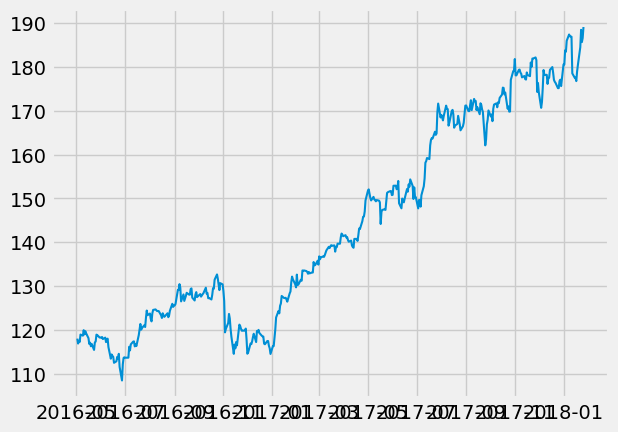

In [49]:
# Visualizar los datos - serie completa
import matplotlib.pyplot as plt
plt.plot(precios_meta)

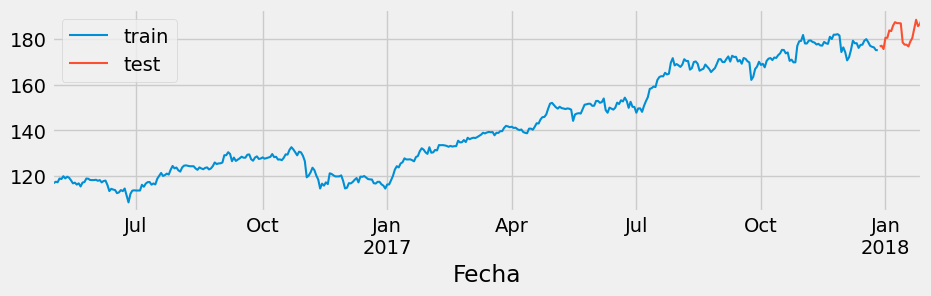

In [50]:
# Visualizar series de training y test en un mismo gráfico
fig, ax = plt.subplots(figsize=(10, 2.5))
precios_meta_train['y'].plot(ax=ax, label='train')
precios_meta_test['y'].plot(ax=ax, label='test')
ax.legend();

**Modelo de Random Forest**

In [51]:
# Creación de Forecaster para generación de ventanas con retrazos
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 8
)

forecaster.fit(y = precios_meta_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-05-02 00:00:00'), Timestamp('2017-12-26 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-12 01:32:41 
Last fit date: 2025-05-12 01:32:41 
Skforecast version: 0.11.0 
Python versio

In [52]:
# Predicción de siguientes n períodos
predicciones = forecaster.predict(steps = steps)
predicciones.head()

2017-12-27    175.6250
2017-12-28    176.7707
2017-12-29    177.6478
2018-01-01    178.5753
2018-01-02    178.4707
Freq: B, Name: pred, dtype: float64

In [53]:
# Calcular métricas de error sobre el pronóstico
rmse_randomforest = sqrt(mean_squared_error(
                        y_true = precios_meta_test['y'],
                        y_pred = predicciones
                    ))
print(f"RMSE Random Forest: {rmse_randomforest}")

RMSE Random Forest: 5.98948527145335


In [54]:
import numpy as np

# Calcular MAPE
mape_randomforest = np.mean(np.abs((precios_meta_test['y'] - predicciones) / precios_meta_test['y']))

print(f"MAPE Random Forest: {mape_randomforest:.2f}")


MAPE Random Forest: 0.03


In [64]:
# Optimización de hiperparametros usando Grudsearch

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 
             )

# Lags used as predictors
lags_grid = [10]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = precios_meta_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(precios_meta_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        n_jobs=1  # <--- desactiva el paralelismo
               )

Number of models compared: 6.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 29.342430261599233



In [66]:
# Imprimir resultados de grid search
results_grid 

,lags,params,mean_squared_error,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",29.342430,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",29.363945,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",33.185986,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",33.234613,10,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",33.775336,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",33.995026,3,500


In [67]:
# Correr el modelo optimizado
regressor = RandomForestRegressor(max_depth= 5, n_estimators=500 , random_state=123)


forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                )

forecaster.fit(y=precios_meta_train['y'])
f = forecaster.fit(y=precios_meta_train['y'])

In [68]:
# Imprimir importancia de los lags
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.331145
1,lag_2,0.196522
2,lag_3,0.254371
3,lag_4,0.096301
4,lag_5,0.075665
5,lag_6,0.021738
6,lag_7,0.005529
7,lag_8,0.006849
8,lag_9,0.003592
9,lag_10,0.008290


In [69]:
# Pronostico siguientes períodos
predicciones_random_forest = forecaster.predict(steps=steps)
predicciones_random_forest.head(5)

2017-12-27    175.910599
2017-12-28    176.656312
2017-12-29    176.753162
2018-01-01    177.092861
2018-01-02    178.176010
Freq: B, Name: pred, dtype: float64

In [70]:
df_predicciones_random_forest = pd.DataFrame(predicciones_random_forest)

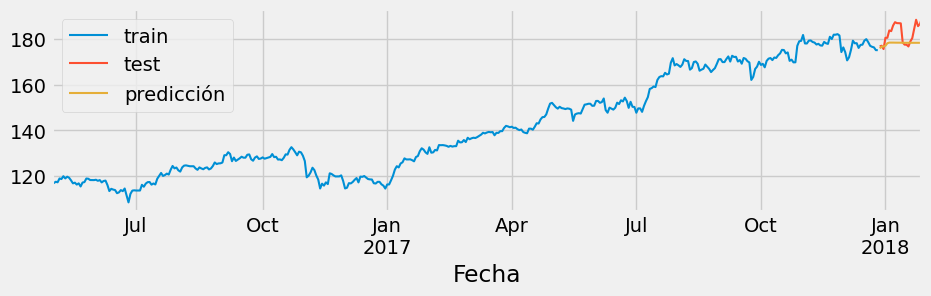

In [71]:
fig, ax = plt.subplots(figsize=(10, 2.5))
precios_meta_train['y'].plot(ax=ax, label='train')
precios_meta_test['y'].plot(ax=ax, label='test')
df_predicciones_random_forest['pred'].plot(ax=ax, label='predicción')
ax.legend();

In [72]:
# Calcular métricas de error sobre el pronóstico
rmse_randomforest = sqrt(mean_squared_error(
                        y_true = precios_meta_test['y'],
                        y_pred = df_predicciones_random_forest['pred']
                    ))
print(f"RMSE Random Forest: {rmse_randomforest}")

RMSE Random Forest: 5.940042807632336


In [73]:
import numpy as np

# Calcular MAPE
mape_randomforest = np.mean(np.abs((precios_meta_test['y'] - df_predicciones_random_forest['pred']) / precios_meta_test['y']))

print(f"MAPE Random Forest: {mape_randomforest:.2f}")


MAPE Random Forest: 0.03


In [74]:
mean_squared_error(
                        y_true = precios_meta_test['y'],
                        y_pred = df_predicciones_random_forest['pred']
                    )

35.28410855650465

**Modelo LSTM**

In [75]:
# Crear ventanas de tiempo
n_back = 10   #Longitud de ventana
train_generator = TimeseriesGenerator(precios_meta_train['y'], precios_meta_train['y'], length=n_back, batch_size=32)
test_generator = TimeseriesGenerator(precios_meta_test['y'], precios_meta_test['y'], length=n_back, batch_size=1)

In [76]:
# Número de muestras generadas (ventanas)
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))

Samples: 14
Samples: 13


In [77]:
# Diseño de la red neuronal LSTM

# Librerias necesarias
from keras.models import Sequential
from keras.layers import LSTM, Dense

# DIseñar la red
model = Sequential()
model.add(
    LSTM(200,  
        activation='relu',
        input_shape=(n_back,1))  
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30

model.fit(train_generator, epochs=num_epochs, verbose=0)

In [78]:
# Ajuste del modelo a los datos:
historico = model.fit(train_generator, epochs=num_epochs, verbose=0)

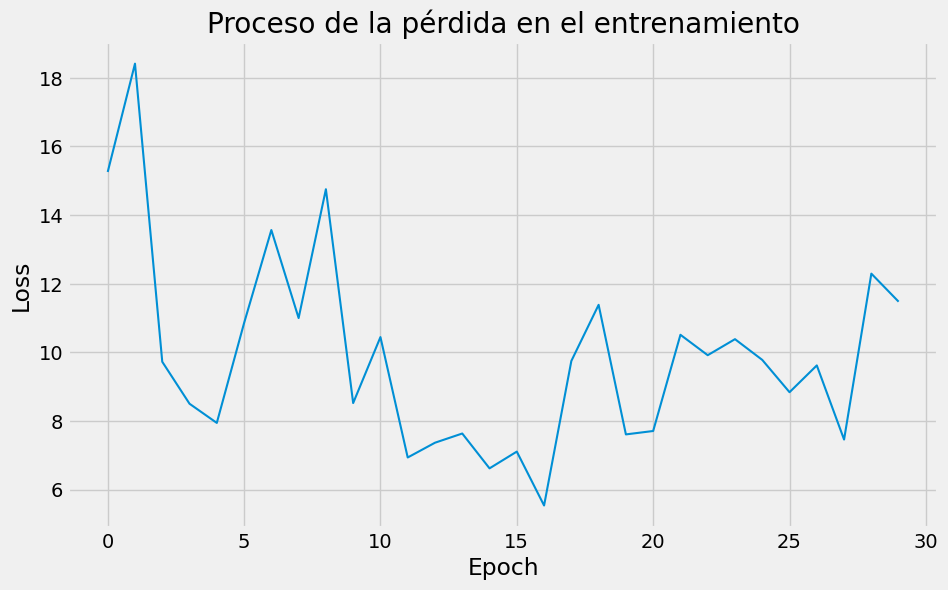

In [79]:
# Mostrar comportamiento de la función de pérdida con el aumento de los epochs

import seaborn as sns
import matplotlib.pyplot as plt

# Crear DataFrame desde el historial del entrenamiento
hist = pd.DataFrame(historico.history)
hist['epoch'] = historico.epoch

# Gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='loss', data=hist)
plt.title('Proceso de la pérdida en el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [80]:
# fast_mode=True  # Puedes cambiar a True para búsqueda completa
# best_model, best_hp = optimize_lstm_univariate(
#     input_data=precios_meta_train['y'],
#     output_data=precios_meta_train['y'],
#     dataindex=precios_meta_index,
#     n_back=10,
#     batch_size=10,  ## si no hay tiempo, pueden bajar este parámetro
#     max_trials=10,
#     epochs=30,

# )

In [81]:
# Diseño de la red neuronal LSTM

# Librerias necesarias
from keras.models import Sequential
from keras.layers import LSTM, Dense

# DIseñar la red
model = Sequential()
model.add(
    LSTM(200,  
        activation='relu',
        input_shape=(n_back,1))  
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30

model.fit(train_generator, epochs=num_epochs, verbose=0)

In [82]:
# Pronosticar siguientes períodos
prediccion_LSTM = model.predict(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
prediccion_LSTM = prediccion_LSTM.reshape((-1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [83]:
import numpy as np

# Ventana inicial: últimos valores del entrenamiento
input_seq = precios_meta_test['y'].values[-n_back:].reshape(1, n_back, 1)

# Lista para guardar predicciones
predicciones = []

# Generar 23 pasos
for _ in range(len(precios_meta_test)):
    # Predecir el siguiente paso
    pred = model.predict(input_seq, verbose=0)[0, 0]
    predicciones.append(pred)
    
    # Deslizar la ventana e incluir la nueva predicción
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)



In [84]:
df_prediccion_LSTM = pd.DataFrame(predicciones).rename(columns={0:'pred'})
df_prediccion_LSTM = df_prediccion_LSTM.set_index(precios_meta_test.index)

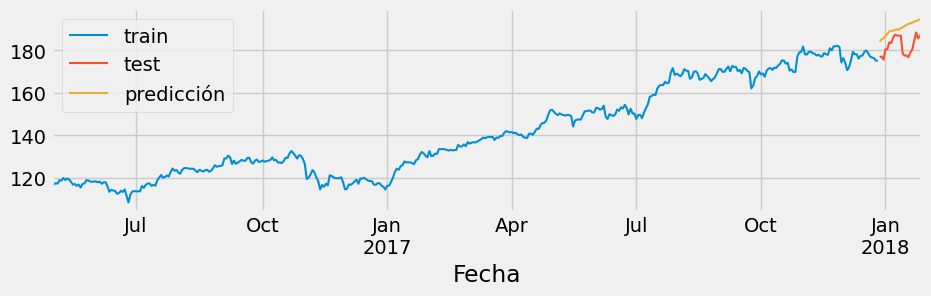

In [85]:
fig, ax = plt.subplots(figsize=(10, 2.5))
precios_meta_train['y'].plot(ax=ax, label='train')
precios_meta_test['y'].plot(ax=ax, label='test')
df_prediccion_LSTM['pred'].plot(ax=ax, label='predicción')
ax.legend();

In [86]:
# Calcular métricas de error sobre el pronóstico
rmse_randomforest = sqrt(mean_squared_error(
                        y_true = precios_meta_test['y'],
                        y_pred = df_prediccion_LSTM['pred']
                    ))
print(f"RMSE LSTM: {rmse_randomforest}")

RMSE LSTM: 8.962286402789976


In [87]:
import numpy as np

# Calcular MAPE
mape_randomforest = np.mean(np.abs((precios_meta_test['y'] - df_prediccion_LSTM['pred']) / precios_meta_test['y']))

print(f"MAPE LSTM: {mape_randomforest:.2f}")


MAPE LSTM: 0.04
